# Imports

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Activation, Conv1D, Dropout, Dense, Flatten,  MaxPooling1D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import *
import keras
import tensorflow
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
import string
%matplotlib inline
import csv


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data Preparation

In [4]:
# upload the csv to your google drive and import from your google drive directory to save upload time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BT4012/data_39.csv', engine='python', on_bad_lines='warn', encoding= "UTF-8")
data

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,...,company_profile_length,requirements_length,benefits_length,description_length,country,state,city,min_salary,max_salary,salary_specified
0,marketing intern,Marketing,food52 create groundbreaking award win cooking...,food52 fast grow james beard award win online ...,experience content management system major plu...,NaN,0,1,0,Other,...,90,77,0,84,US,NY,New York,0,0,0
1,customer service cloud video production,Success,90 second world cloud video production service...,organise focus vibrant awesome passion custome...,expect key responsibility communicate client 9...,get usthrough part 90 second team gain experie...,0,1,0,Full-time,...,122,123,117,208,NZ,Unspecified,Auckland,0,0,0
2,commission machinery assistant cma,NaN,valor service provide workforce solution meet ...,client locate houston actively seek experience...,implement pre commission commission procedure ...,NaN,0,1,0,NaN,...,79,123,0,30,US,IA,Wever,0,0,0
3,account executive washington dc,Sales,passion improve quality life geography heart e...,company esri environmental system research ins...,education bachelor master gi business administ...,culture anything corporate collaborative creat...,0,1,0,Full-time,...,58,124,79,226,US,DC,Washington,0,0,0
4,bill review manager,NaN,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualification right license state texasdiploma...,full benefit offer,0,1,1,Full-time,...,155,66,3,131,US,FL,Fort Worth,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,account director distribution,Sales,vend look awesome new talent come join u work ...,case first time visit website vend award win w...,ace role eat comprehensive statement work brea...,expect u open culture openly share result inpu...,0,1,1,Full-time,...,170,113,78,132,CA,ON,Toronto,0,0,0
17876,payroll accountant,Accounting,weblinc e commerce platform service provider f...,payroll accountant focus primarily payroll fun...,b b accounting desire fun love genuine passion...,health amp wellnessmedical planprescription dr...,0,1,1,Full-time,...,204,67,52,119,US,PA,Philadelphia,0,0,0
17877,project cost control staff engineer cost contr...,NaN,provide full time permanent position many medi...,experienced project cost control staff enginee...,least 12 year professional experience ability ...,NaN,0,0,0,Full-time,...,23,98,0,120,US,TX,Houston,0,0,0
17878,graphic designer,NaN,NaN,nemsia studio look experienced visual graphic ...,1 must fluent late version corel amp adobe cc ...,competitive salary compensation base experienc...,0,0,1,Contract,...,0,58,20,43,NG,LA,Lagos,0,0,0


In [ ]:
data.head(1)

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,...,company_profile_length,requirements_length,benefits_length,description_length,country,state,city,min_salary,max_salary,salary_specified
0,marketing intern,Marketing,food52 create groundbreaking award win cooking...,food52 fast grow james beard award win online ...,experience content management system major plu...,NaN,0,1,0,Other,...,90,77,0,84,US,NY,New York,0,0,0


In [ ]:
data.info()

In [ ]:
# see how combined text looks like after cleaning and processing
data['combined_text'][0]

' marketing intern food52 create groundbreaking award win cooking site support connect celebrate home cook give everything need one place top editorial business engineering team focus use technology find new well way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well know professional like mario batali gwyneth paltrow danny meyer partnership whole food market random house food52 name best food website james beard foundation iacp feature new york time npr pando daily techcrunch today show locate chelsea new york city food52 fast grow james beard award win online food community crowd source curated recipe hub currently interview full part time unpaid intern work small team editor executive developer new york city headquarters reproduce repackaging exist food52 content number partner site huffington post yahoo buzzfeed various content management systemsresearching blog website p

In [ ]:
# Tokenize 'combined_text' to split paragraphs and sentences into smaller units that can be more easily assigned meaning.   

tokenizer = Tokenizer(num_words = 25000, split = ' ')
tokenizer.fit_on_texts(data['combined_text'].values)
word_index = tokenizer.word_index
X_text = tokenizer.texts_to_sequences(data['combined_text'].values)
max_sequence = max(len(x) for x in X_text)
X_text = pad_sequences(X_text, maxlen = max_sequence)

In [ ]:
# use the stratified version of train/test/validation split to solve the issue of imbalanced dataset which helps to preserve the class distribution
X = X_text
y = data['fraudulent']

train_text , test_text , train_fraud , test_fraud = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
train_text, val_text, train_fraud, val_fraud = train_test_split(train_text, train_fraud, test_size=0.25, random_state=1, stratify=train_fraud) # 0.25 x 0.8 = 0.2

In [ ]:
# show distribution of test and train
train_0, train_1 = len(train_fraud[train_fraud==0]), len(train_fraud[train_fraud==1])
test_0, test_1 = len(test_fraud[test_fraud==0]), len(test_fraud[test_fraud==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=9570, 1=487, Test: 0=4253, 1=217


# CNN


In [ ]:
# Optimising Parameter for Filter size

df = pd.DataFrame(columns = ['kernel_size', 'train_loss', 'train_r2'])

def update():
  filter_list = []
  train_loss_list = []
  train_r2_list = []
  test_loss_list = []
  test_r2_list = []
  for j in range(2,6): # testing kernel size of 2x2 to 6x6
    cnn_model = Sequential() 
    cnn_model.add(Embedding(len(word_index)+1, 32, input_length=max_sequence))
    cnn_model.add(Conv1D(32, j, padding='same', activation='relu')) # update the kernel_size
    cnn_model.add(Flatten())
    cnn_model.add(Dense(10, activation='relu'))
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    cnn_history = cnn_model.fit(train_text, train_fraud, validation_data=(val_text, val_fraud), epochs=5, batch_size=1000, verbose=1)
    train_score = cnn_model.evaluate(train_text, train_fraud, verbose=0)
    test_score = cnn_model.evaluate(test_text, test_fraud, verbose=0)
    filter_list.append(j)
    train_loss_list.append(train_score[0])
    train_r2_list.append(r2_score(train_fraud, cnn_model.predict(train_text)))
    test_loss_list.append(test_score[0])
    test_r2_list.append(r2_score(test_fraud, cnn_model.predict(test_text)))
  return filter_list, train_loss_list, train_r2_list, test_loss_list, test_r2_list

filter_res, train_loss_res, train_r2_res, test_loss_res, test_r2_res = update()
df['kernel_size'] = filter_res
df['train_loss'] = train_loss_res
df['train_r2'] = train_r2_res
df['test_loss'] = test_loss_res
df['test_r2'] = test_r2_res

Epoch 1/5
11/11 [==============================] - 26s 2s/step - loss: 0.2605 - accuracy: 0.8739 - val_loss: 0.1932 - val_accuracy: 0.9517
Epoch 2/5
11/11 [==============================] - 25s 2s/step - loss: 0.1885 - accuracy: 0.9516 - val_loss: 0.1818 - val_accuracy: 0.9517
Epoch 3/5
11/11 [==============================] - 24s 2s/step - loss: 0.1735 - accuracy: 0.9516 - val_loss: 0.1664 - val_accuracy: 0.9517
Epoch 4/5
11/11 [==============================] - 27s 2s/step - loss: 0.1555 - accuracy: 0.9516 - val_loss: 0.1469 - val_accuracy: 0.9517
Epoch 5/5
140/140 [==============================] - 6s 39ms/step
Epoch 1/5
11/11 [==============================] - 31s 3s/step - loss: 0.2826 - accuracy: 0.8679 - val_loss: 0.1937 - val_accuracy: 0.9517
Epoch 2/5
11/11 [==============================] - 30s 3s/step - loss: 0.1867 - accuracy: 0.9516 - val_loss: 0.1777 - val_accuracy: 0.9517
Epoch 3/5
11/11 [==============================] - 30s 3s/step - loss: 0.1694 - accuracy: 0.9516 - v

In [ ]:
df

,kernel_size,train_loss,train_r2,test_loss,test_r2
0,2,0.113732,0.272187,0.125894,0.224145
1,3,0.091015,0.377910,0.109133,0.297730
2,4,0.078948,0.451934,0.102242,0.345628
3,5,0.070534,0.493225,0.097495,0.368280


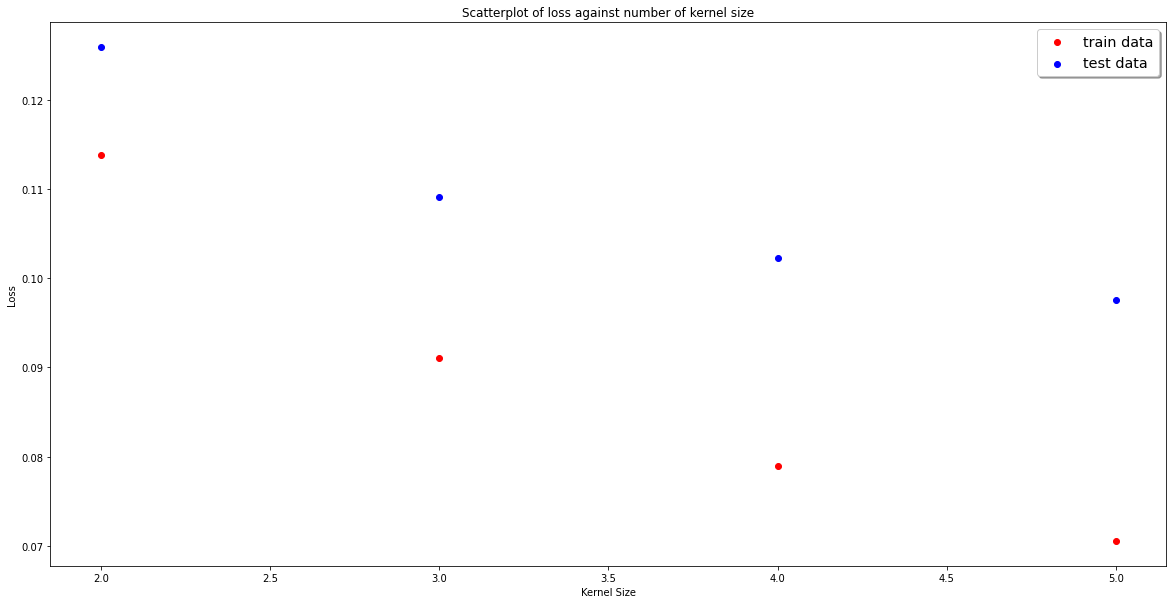

In [ ]:
# Scatterplot for Loss against Kernel_size
ig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(filter_res, train_loss_res, c = 'red', label = 'train data')
ax.scatter(filter_res, test_loss_res, c = 'blue', label = 'test data')
plt.title("Scatterplot of loss against number of kernel size")
plt.xlabel('Kernel Size')
plt.ylabel('Loss')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()


In [ ]:
# Optimising Parameter for num of filters
df1 = pd.DataFrame(columns = ['num_filters', 'train_loss', 'train_r2'])

def update1():
  filter_list = []
  train_loss_list = []
  train_r2_list = []
  test_loss_list = []
  test_r2_list = []
  for j in range(32,512,50): # testing num of filter from 32 to 512
    cnn_model = Sequential() 
    cnn_model.add(Embedding(len(word_index)+1, 32, input_length=max_sequence))
    cnn_model.add(Conv1D(j, 5, padding='same', activation='relu')) # update the kernel_size
    cnn_model.add(Flatten())
    cnn_model.add(Dense(10, activation='relu'))
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    cnn_history = cnn_model.fit(train_text, train_fraud, validation_data=(val_text, val_fraud), epochs=1, verbose=1)
    train_score = cnn_model.evaluate(train_text, train_fraud, verbose=0)
    test_score = cnn_model.evaluate(test_text, test_fraud, verbose=0)
    filter_list.append(j)
    train_loss_list.append(train_score[0])
    train_r2_list.append(r2_score(train_fraud, cnn_model.predict(train_text)))
    test_loss_list.append(test_score[0])
    test_r2_list.append(r2_score(test_fraud, cnn_model.predict(test_text)))
  return filter_list, train_loss_list, train_r2_list, test_loss_list, test_r2_list

filter_res, train_loss_res, train_r2_res, test_loss_res, test_r2_res = update1()
df1['num_filters'] = filter_res
df1['train_loss'] = train_loss_res
df1['train_r2'] = train_r2_res
df1['test_loss'] = test_loss_res
df1['test_r2'] = test_r2_res

140/140 [==============================] - 41s 290ms/step


In [ ]:
df1

,num_filters,train_loss,train_r2,test_loss,test_r2
0,32,0.061784,0.613893,0.087817,0.468399
1,82,0.053247,0.654340,0.085367,0.481778
2,132,0.055421,0.581843,0.111305,0.377021
3,182,0.052743,0.658923,0.080807,0.500535
4,232,0.053985,0.654600,0.082358,0.491905
5,282,0.047619,0.675381,0.080637,0.502640
6,332,0.063298,0.634341,0.090845,0.470897
7,382,0.065069,0.606668,0.090981,0.453660
8,432,0.049430,0.644456,0.090022,0.444622
9,482,0.066776,0.596078,0.093422,0.438337


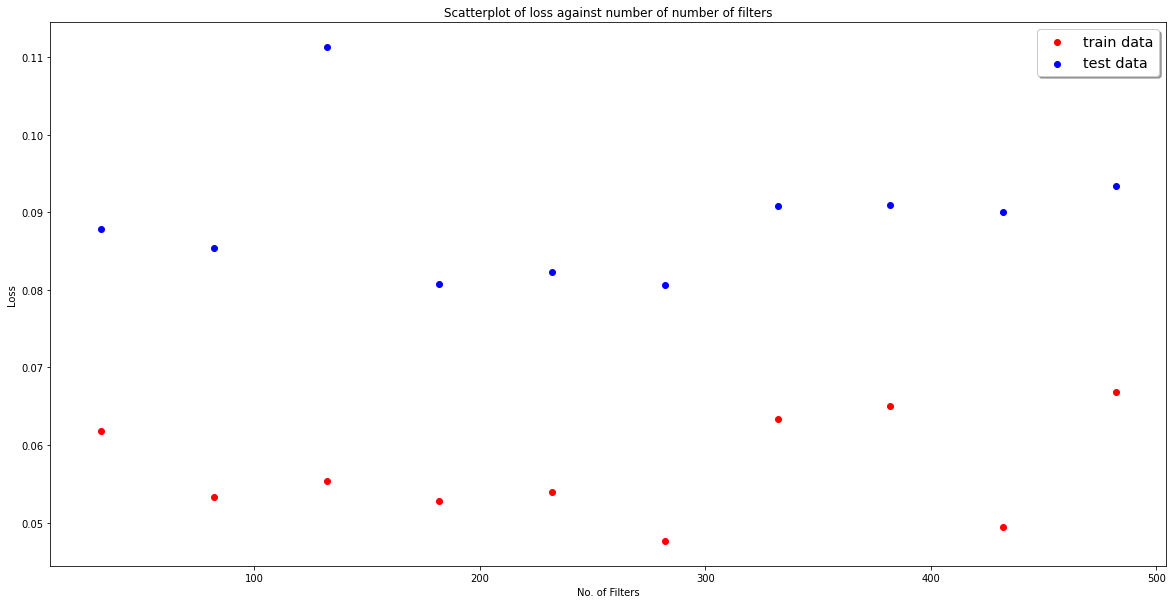

In [ ]:
# Scatterplot for Loss against num of filters
ig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(filter_res, train_loss_res, c = 'red', label = 'train data')
ax.scatter(filter_res, test_loss_res, c = 'blue', label = 'test data')
plt.title("Scatterplot of loss against number of number of filters")
plt.xlabel('No. of Filters')
plt.ylabel('Loss')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()


In [ ]:
# Building the CNN Model with a finalised Kernel_Size of 5x5 and 32 for num of filters
cnn_model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
cnn_model.add(Embedding(len(word_index)+1, 32, input_length=max_sequence))
cnn_model.add(Conv1D(32, 5, padding='same', activation='relu')) 
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()
# Fitting the data onto model
cnn_history = cnn_model.fit(train_text, train_fraud, validation_data=(val_text, val_fraud), epochs=10, batch_size=1000, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2948, 32)          3120448   
                                                                 
 conv1d_2 (Conv1D)           (None, 2948, 32)          5152      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1474, 32)         0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 47168)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                471690    
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                      

In [ ]:
# evaluate the training and testing performance of our CNN model  
score_train = cnn_model.evaluate(train_text, train_fraud, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])

score_test = cnn_model.evaluate(test_text, test_fraud, verbose=0)
print(" ")
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
print(" ")
print('Validation loss:', np.mean(cnn_history.history['val_loss']))
print('Validation accuracy:', np.mean(cnn_history.history['val_accuracy']))

Train loss: 0.047164637595415115
Train accuracy: 0.9860793352127075
 
Test loss: 0.08901854604482651
Test accuracy: 0.9684563875198364
 
Validation loss: 0.13144762068986893
Validation accuracy: 0.9555025458335876


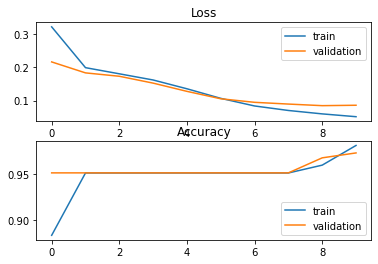

In [ ]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# prediction scores for test for CNN on test
pred = cnn_model.predict(test_text)
pred = np.around(pred , decimals = 0)

140/140 [==============================] - 6s 42ms/step


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_fraud, pred)
print('Test Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_fraud, pred)
print('Test Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_fraud, pred)
print('Test Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_fraud, pred)
print('Test F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(test_fraud, pred)
print('Test Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_fraud, pred)
print('Test ROC AUC: %f' % auc)

Test Accuracy: 0.968456
Test Precision: 0.845455
Test Recall: 0.428571
Test F1 score: 0.568807
Test Cohens kappa: 0.554249
Test ROC AUC: 0.712287


In [ ]:
# prediction scores for test for CNN on validation
pred1 = cnn_model.predict(val_text)
pred1 = np.around(pred1 , decimals = 0)

105/105 [==============================] - 9s 81ms/step


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_fraud, pred1)
print('Validation Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_fraud, pred1)
print('Validation Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_fraud, pred1)
print('Validation Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(val_fraud, pred1)
print('Validation F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(val_fraud, pred1)
print('Validation Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(val_fraud, pred1)
print('Validation ROC AUC: %f' % auc)

Validation Accuracy: 0.973457
Validation Precision: 0.939759
Validation Recall: 0.481481
Validation F1 score: 0.636735
Validation Cohens kappa: 0.624440
Validation ROC AUC: 0.739957


In [ ]:
# prediction scores for test for CNN on train
pred2 = cnn_model.predict(train_text)
pred2 = np.around(pred2 , decimals = 0)

315/315 [==============================] - 16s 50ms/step


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(train_fraud, pred2)
print('Train Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(train_fraud, pred2)
print('Train Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(train_fraud, pred2)
print('Train Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(train_fraud, pred2)
print('Train F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(train_fraud, pred2)
print('Train Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(train_fraud, pred2)
print('Train ROC AUC: %f' % auc)

Train Accuracy: 0.986079
Train Precision: 0.972752
Train Recall: 0.733060
Train F1 score: 0.836066
Train Cohens kappa: 0.828946
Train ROC AUC: 0.866007


In [ ]:
# classification report to show main classification metrics
cv_report = classification_report(test_fraud, pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4253
           1       0.97      0.14      0.24       217

    accuracy                           0.96      4470
   macro avg       0.96      0.57      0.61      4470
weighted avg       0.96      0.96      0.94      4470



In [ ]:
# Plotting the confusion matrix 
# cm_cv = confusion_matrix(test_fraud,pred)
# cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
# cm_cv.index.name = 'Actual'
# cm_cv.columns.name = 'Predicted'
# cm_cv

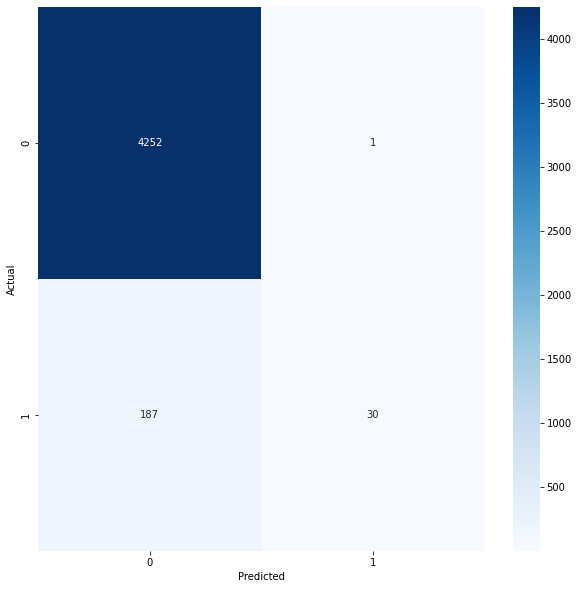

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

#FCNN (Not our Final Model)

In [ ]:
# Parameter optimising for FCNN to decide on the num of neurons to use

df1 = pd.DataFrame(columns = ['num_neurons', 'train_loss', 'train_r2'])

def update_neurons():
  neurons_list = []
  train_loss_list = []
  train_r2_list = []
  test_loss_list = []
  test_r2_list = []
  for j in range(5, 101, 5):
    model = Sequential()
    model.add(Dense(units = j , activation = 'relu' , input_dim = train_text.shape[1]))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.fit(train_text, train_fraud, batch_size=100, epochs = 5)
    train_score = model.evaluate(train_text, train_fraud, verbose=0)
    test_score = model.evaluate(test_text, test_fraud, verbose=0)
    neurons_list.append(j)
    train_loss_list.append(train_score[0])
    train_r2_list.append(r2(train_fraud, model.predict(train_text)))
    test_loss_list.append(test_score[0])
    test_r2_list.append(r2(test_fraud, model.predict(test_text)))
  return neurons_list, train_loss_list, train_r2_list, test_loss_list, test_r2_list

neurons_res, train_loss_res1, train_r2_res1, test_loss_res1, test_r2_res1 = update_neurons()
df1['num_neurons'] = neurons_res
df1['train_loss'] = train_loss_res1
df1['train_r2'] = train_r2_res1
df1['test_loss'] = test_loss_res1
df1['test_r2'] = test_r2_res1



Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 89.6933 - accuracy: 0.9273
Epoch 2/5
101/101 [==============================] - 0s 4ms/step - loss: 1.7460 - accuracy: 0.9500
Epoch 3/5
101/101 [==============================] - 0s 4ms/step - loss: 0.9098 - accuracy: 0.9511
Epoch 4/5
101/101 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.9517
Epoch 5/5
140/140 [==============================] - 0s 2ms/step
Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 21.3562 - accuracy: 0.9132
Epoch 2/5
101/101 [==============================] - 0s 5ms/step - loss: 0.7642 - accuracy: 0.9519
Epoch 3/5
101/101 [==============================] - 0s 5ms/step - loss: 0.5485 - accuracy: 0.9518
Epoch 4/5
101/101 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.9519
Epoch 5/5
140/140 [==============================] - 0s 2ms/step
Epoch 1/5
101/101 [==============================] - 1s 4ms/step - loss: 22.

In [ ]:
df1

,num_neurons,train_loss,train_r2,test_loss,test_r2
0,5,0.509646,-2.303242,1.341536,-2.333538
1,10,0.247265,-0.247483,0.391421,-0.295183
2,15,0.218293,0.022607,0.702720,-0.092844
3,20,0.274462,-0.206708,1.321890,-0.419378
4,25,0.131646,0.288621,1.159461,-0.111661
5,30,0.196364,0.194373,2.075661,-0.295360
6,35,0.337784,-1.165132,2.750440,-1.549292
7,40,0.192677,0.087200,3.196332,-0.318620
8,45,0.157800,0.111623,3.047142,-0.339202
9,50,0.221433,0.075778,3.200891,-0.428732


In [ ]:
# Parameter optimising for FCNN to decide on the num of layers to use with 10 neurons

df = pd.DataFrame(columns = ['num_layers', 'train_loss', 'train_r2'])

def update():
  layers_list = []
  train_loss_list = []
  train_r2_list = []
  test_loss_list = []
  test_r2_list = []
  for j in range(1, 20):
    model = Sequential()
    model.add(Dense(units = 100 , activation = 'relu' , input_dim = train_text.shape[1]))
    for i in range(j):
      model.add(Dense(units = 10 , activation = 'relu'))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.fit(train_text, train_fraud, batch_size=100, epochs = 5)
    train_score = model.evaluate(train_text, train_fraud, verbose=0)
    test_score = model.evaluate(test_text, test_fraud, verbose=0)
    layers_list.append(j)
    train_loss_list.append(train_score[0])
    train_r2_list.append(r2(train_fraud, model.predict(train_text)))
    test_loss_list.append(test_score[0])
    test_r2_list.append(r2(test_fraud, model.predict(test_text)))
  return layers_list, train_loss_list, train_r2_list, test_loss_list, test_r2_list

layers_res, train_loss_res, train_r2_res, test_loss_res, test_r2_res = update()
df['num_layers'] = layers_res
df['train_loss'] = train_loss_res
df['train_r2'] = train_r2_res
df['test_loss'] = test_loss_res
df['test_r2'] = test_r2_res


In [ ]:
df

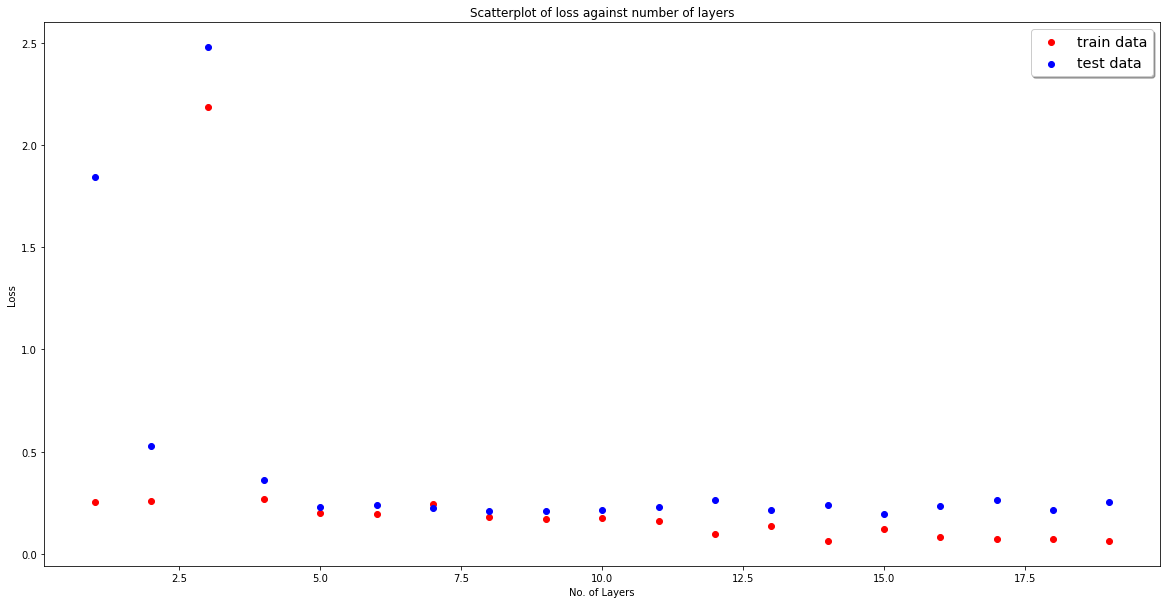

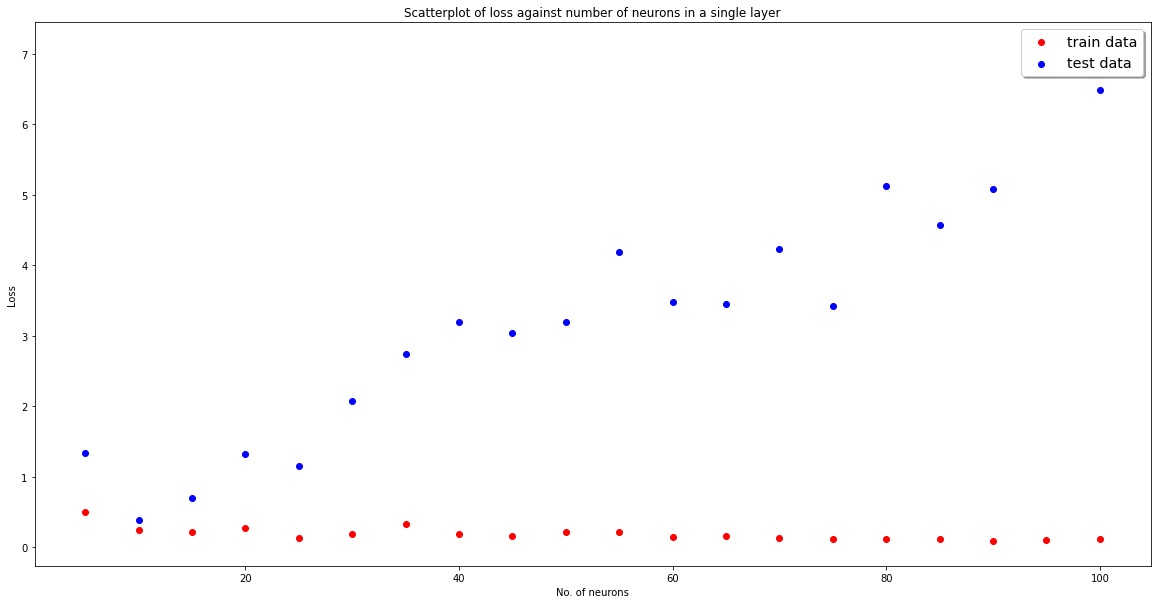

In [ ]:
# Scatterplot for loss against number of layers
ig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(layers_res, train_loss_res, c = 'red', label = 'train data')
ax.scatter(layers_res, test_loss_res, c = 'blue', label = 'test data')
plt.title("Scatterplot of loss against number of layers")
plt.xlabel('No. of Layers')
plt.ylabel('Loss')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

# Scatterplot for loss against number of neurons

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(neurons_res, train_loss_res1, c = 'red', label = 'train data')
ax.scatter(neurons_res, test_loss_res1, c = 'blue', label = 'test data')
plt.title("Scatterplot of loss against number of neurons in a single layer")
plt.xlabel('No. of neurons')
plt.ylabel('Loss')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

In [ ]:
# We have finalised and set to 10 neurons and 5 hidden layers
fcnn_model = Sequential()
fcnn_model.add(Dense(units = 10 , activation = 'relu' , input_dim = train_text.shape[1]))
for layer in range(5):
  fcnn_model.add(layers.Dense(10, activation='relu'))
fcnn_model.add(Dense(units = 1 , activation = 'sigmoid'))
fcnn_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
fcnn_model.summary()
fcnn_history = fcnn_model.fit(train_text, train_fraud, batch_size=100, epochs = 10)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_268 (Dense)           (None, 10)                29490     
                                                                 
 dense_269 (Dense)           (None, 10)                110       
                                                                 
 dense_270 (Dense)           (None, 10)                110       
                                                                 
 dense_271 (Dense)           (None, 10)                110       
                                                                 
 dense_272 (Dense)           (None, 10)                110       
                                                                 
 dense_273 (Dense)           (None, 10)                110       
                                                                 
 dense_274 (Dense)           (None, 1)               

In [ ]:
# evaluate the training and testing performance of our FCNN model  
score_train = fcnn_model.evaluate(train_text, train_fraud, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])

score_test = fcnn_model.evaluate(test_text, test_fraud, verbose=0)
print(" ")
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Train loss: 0.17304165661334991
Train accuracy: 0.9515759944915771
 
Test loss: 0.24202269315719604
Test accuracy: 0.9510067105293274


In [ ]:
# prediction scores for test for FCNN
pred = fcnn_model.predict(test_text)
pred = np.around(pred , decimals = 0)

140/140 [==============================] - 0s 2ms/step


In [ ]:
# classification report to show main classification metrics
cv_report = classification_report(test_fraud, pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4253
           1       0.25      0.00      0.01       217

    accuracy                           0.95      4470
   macro avg       0.60      0.50      0.49      4470
weighted avg       0.92      0.95      0.93      4470



In [ ]:
# Plotting the confusion matrix 
cm_cv = confusion_matrix(test_fraud,pred)
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
cm_cv

Predicted,0,1
Actual,,
0,4250,3
1,216,1


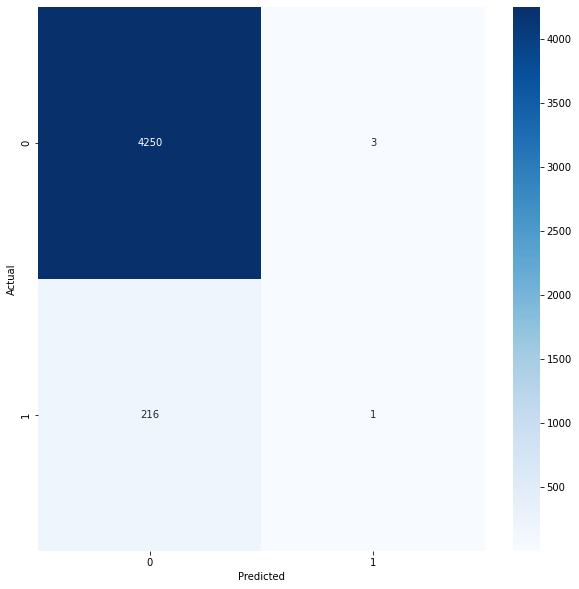

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')